## Task 3

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [107]:
class Cliff_Environment: 
    def __init__(self, 
                 n_rows = 4, 
                 n_columns = 21,
                 S = (3, 0),
                 G = (3, 20),
                 setup = "Normal",
                 snakes_location = [(1, 10),(2, 10)]):
        # Registering all the attributes
        self.n_rows = n_rows
        self.n_columns = n_columns
        self.start = S
        self.terminal = G

        # Defining the States
        self.grid = pd.DataFrame(-1, index=range(3), columns=range(21))
        self.grid.loc[S] = -1
        self.grid.loc[G] = 20

        if setup == "Normal":
            self.grid.loc[self.n_rows - 1, 1:self.n_columns - 2] = -100
        
        if setup == "Snake_Pit":
            self.grid.loc[self.n_rows - 1, 1:self.n_columns - 2] = -100
            for location in snakes_location:
                self.grid.loc[location] = -100

        
        # Cliff Status
        self.terminated = False


    def Available_Actions(self, state):
        '''
        Given the position on the grid -- state -- (e.g., (0,3)), give the available actions that can be taken.
        '''
        row, col = state
        n_rows = self.n_rows
        n_cols = self.n_columns

        # Check if input is meaningful
        if row > n_rows-1 or col > n_cols-1:
            raise ValueError("Given value not within the grid!!!")

        # First column limits: 
        elif col == 0:
            # Bottom Row
            if row == n_rows-1:
                return ("Up", "Right")
            # Top Row
            elif row == 0:
                return ("Down", "Right")
            else:
                return ("Up", "Down", "Right")
            
        # Last column limits: 
        elif col == n_cols-1:
            # Bottom Row
            if row == n_rows-1:
                return () # Task Completed
            # Top Row
            elif row == 0:
                return ("Down", "Left")
            else:
                return ("Up", "Down", "Left")
            
        # Top Row Limit
        elif row == 0:
            return ("Down", "Left", "Right")
        
        # Last Row Limit (only the cliff part left)
        elif row == n_rows-1:
            return () # Cliff Fallen
        
        # No Limit
        else:
            return ("Up", "Down", "Left", "Right")


    def Transition(self, action, state, actually_transition = False):
        '''
        Given the available actions, the agent chooses an action. This action leads to transitioning to a new state.

        Here, this function essentially needs the state and the action. The action provides action, and agent provides state.

        The function returns the new to-be position of the agent.
        '''
        # if needed: Initializing new_state to the current state to avoid "UnboundLocalError"
        
        if action == "Up":
            new_state = (state[0] - 1, state[1])
        if action == "Down":
            new_state = (state[0] + 1, state[1])
        if action == "Right":
            new_state = (state[0], state[1] + 1)
        if action == "Left":
            new_state = (state[0], state[1] - 1)
        
        if actually_transition == False:
            return new_state
        if actually_transition == True: 
            # Cliff Condition
            if new_state == self.terminal:
                self.terminated = True
            if self.grid.loc[new_state] == -100:
                self.terminated = True
            
            # Alter the agent.state and available actions if transitioned
            return new_state
                

    def Reward_Value_Given_State(self, state):
        '''
        When the agent transitions to a new state, they get the reward associated with that state.
        '''
        return self.grid.loc[state]

In [178]:
class Cliff_Walking:
    def __init__(self, 
                 cliff_environment,
                 strategy,
                 n_episodes = 1000,
                 epsilon = 0.1, # exploration rate
                 decrease_epsilon = True,
                 epsilon_decay = "linear",
                 alpha=0.5, # learning rate
                 gamma=0.9,
                 ############### REPLAY BUFFER ###############
                 use_replay_buffer = False,
                 buffer_max_size=1000,
                 batch_size=25,
                 sample_buffer_after_n_moves = 50,
                 ############### REPLAY BUFFER ###############
                 max_moves = 500,
                 n_runs = 10
                 ):
        '''
        Available strategies are "SARSA" and "Q-learning". 
        You can further specify a replay buffer for Q-learning.
        '''

        # Getting the Environment
        self.environment = cliff_environment
        self.n_episodes = n_episodes

        # Registering the alpha and epsilon variables, and the strategy
        self.initial_epsilon = epsilon
        self.decrease_epsilon = decrease_epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.strategy = strategy

        # Initializing the q-table
        actions = ['Up', 'Down', 'Left', 'Right']
        index = pd.MultiIndex.from_product([range(cliff_environment.n_rows), range(cliff_environment.n_columns)], names=['Row', 'Column'])
        self.q_table = pd.DataFrame(0, index=index, columns=actions).astype(float) # astype(float) is important as further isues arise if not
        self.q_table_0 = self.q_table

        # Initializing the starting position
        self.state = self.environment.start
        self.available_actions = self.environment.Available_Actions(state = self.state)
        
        # Initializing a rewards list
        self.episode_rewards = []
        # Initializing history
        self.history = {}

        # Optimal Path
        ## Setting up the df
        self.optimal_path = self.environment.grid.astype(int)
        self.optimal_path.replace(-1, 0, inplace=True)
        self.optimal_path.replace(-100, -1, inplace=True)
        self.optimal_path_0 = self.optimal_path

        #self.optimal_path = pd.DataFrame(0, index=range(self.environment.n_rows), columns=range(self.environment.n_columns)).astype(int)
        ## Putting the Cliff, Start, and Terminal
        #self.optimal_path.loc[self.environment.n_rows - 1, 1:self.environment.n_columns - 2] = -1

        # self.optimal_path.loc[self.environment.n_rows -1, 0] = 0
        # self.optimal_path.loc[self.environment.n_rows -1, self.environment.n_columns - 1] = 2

        ############### REPLAY BUFFER ###############
        # For Q-learning
        self.use_replay_buffer = use_replay_buffer
        if self.use_replay_buffer: 
            self.replay_buffer = self.ReplayBuffer(
                buffer_max_size= buffer_max_size,
                batch_size = batch_size)
            self.buffer_sample_time = sample_buffer_after_n_moves
        ############### REPLAY BUFFER ###############
        self.max_moves = max_moves
        self.current_moves_in_epsiode = 0
        
    ############### REPLAY BUFFER ###############
    class ReplayBuffer:
            def __init__(self, buffer_max_size, batch_size):
                self.past_experiences = []
                self.batch_size = batch_size
                self.buffer_max_size = buffer_max_size
                self.move_counter = 0

            def add(self, experience):
                if len(self.past_experiences) >= self.buffer_max_size:
                    self.past_experiences.pop(0)
                self.past_experiences.append(experience)
                self.move_counter += 1
 
            def sample(self):
                sample = random.sample(self.past_experiences, self.batch_size)
                # Sampling from the replay_buffer resets the move_counter
                self.move_counter = 0
                return sample

            def __len__(self):
                return len(self.past_experiences)
    ############### REPLAY BUFFER ############### 

    def update_available_actions(self):
        self.available_actions = self.environment.Available_Actions(state = self.state)
    

    def Best_Action_given_State_Q_values(self, state):
        # Not using self.available_actions to generalize it to the replay buffer stuff, had a problem with it and changed it.
        available_actions = self.environment.Available_Actions(state)

        q_values = {}
        for action in available_actions:
            q_values[action] = self.q_table.loc[state][action] # changed the [to_be_state]
        
        # Find the maximum Q-value among the actions
        max_q_value = max(q_values.values())
        # Create a list of actions that have the maximum Q-value
        actions_with_max_q_value = [action for action, value in q_values.items() if value == max_q_value]

        # Randomly selecting an action if there is a tie
        action = np.random.choice(actions_with_max_q_value)

        return action
    

    def Update_Optimal_Path(self):
        self.environment.terminated = False
        self.state = self.environment.start
        self.update_available_actions()

        counter = 0
        while not self.environment.terminated and counter < 100:
            self.optimal_path.loc[self.state] = 1

            optimal_action = self.Best_Action_given_State_Q_values(state = self.state)
            self.state = self.environment.Transition(action = optimal_action, state = self.state, actually_transition = True)
            self.update_available_actions()
            counter += 1
            # When reached the terminal state, want to turn that into True too!
            if self.environment.terminated:
                self.optimal_path.loc[self.state] = 1
    
    
    def Q_learning__update_Q_table(self, S, A, reward, S_prime, replay_buffer = False, terminated = None):
        if replay_buffer and terminated is None:
            raise ValueError("You must specify whether the game is 'terminated' when 'replay_buffer' is set to True.")

        # Q-learning Q-table Update when S_prime is terminal
        if replay_buffer and terminated:
            self.q_table.loc[S][A] += self.alpha * (reward - self.q_table.loc[S][A])

        elif replay_buffer == False and self.available_actions == ():
            self.q_table.loc[S][A] += self.alpha * (reward - self.q_table.loc[S][A])
      
        # Q-learning Q-table Update when S_prime is not terminal
        else:
            # The action that gives highest q in s_prime
            highest_q_action_at_state_S_prime = self.Best_Action_given_State_Q_values(state = S_prime)
            max_future_q = self.q_table.loc[S_prime][highest_q_action_at_state_S_prime]
            self.q_table.loc[S][A] += self.alpha * (reward + (self.gamma * max_future_q) - self.q_table.loc[S][A])


    def Action_Choice_based_on_GreedyPolicy(self):
        '''
        This method selects an action based either on the highest Q-value (exploitation) or randomly for exploration.
        '''
        # Random if
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.available_actions)
        # Else, take the greedy action:
        else:

            q_values = {}
            for action in self.available_actions:
                # to_be_state = self.environment.Transition(action=action, state=self.state)
                q_values[action] = self.q_table.loc[self.state][action] # changed the [to_be_state]

            # Find the maximum Q-value among the actions
            max_q_value = max(q_values.values())
            # Create a list of actions that have the maximum Q-value
            actions_with_max_q_value = [action for action, value in q_values.items() if value == max_q_value]

            # Randomly selecting an action if there is a tie
            action = np.random.choice(actions_with_max_q_value)

        return action
    
    
    def run(self):
        # I should actually reset the agent here if not have done so

        for episode in range(self.n_episodes):
            # If specified, decrease exploration as we get more information over time
            if self.decrease_epsilon is True:
                if self.epsilon_decay == "exponential":
                    self.epsilon *= 0.99
                if self.epsilon_decay == "linear":
                    self.epsilon -= (self.epsilon/self.n_episodes)
            
            # At the start of every episode, resetting the agent and environment parameters
            self.environment.terminated = False
            self.state = self.environment.start
            self.update_available_actions()
            
            # Initializing the cumulative reward and history
            cumulative_reward = 0
            self.history[episode] = []

            if self.max_moves != None:
                self.current_moves_in_epsiode = 0

            ############################## SARSA ##############################
            if self.strategy == "SARSA":
                
                action_choice = self.Action_Choice_based_on_GreedyPolicy()

                while not self.environment.terminated and (self.max_moves is None or self.current_moves_in_epsiode < self.max_moves):

                    # Saving S and A before tranisitioning
                    S = self.state
                    self.history[episode].append(S)
                    A = action_choice

                    # Taking action and transitioning
                    S_prime = self.environment.Transition(action = action_choice, state=self.state, actually_transition = True)
                    # observing a reward, and updating the possible actions
                    reward = self.environment.Reward_Value_Given_State(state = S_prime)
                    cumulative_reward += reward

                    # Updating the self.state and the available actions
                    self.state = S_prime
                    self.update_available_actions()
                    
                    if self.max_moves != None:
                        self.current_moves_in_epsiode += 1
                
                    # SARSA Q-value update when S_prime is terminal
                    if self.available_actions == ():
                        Q_update = self.alpha * (reward - self.q_table.loc[S][A])
                        self.q_table.loc[S][A] += Q_update
                        # Also adding it to the history
                        self.history[episode].append(S)
                        break

                    else:
                        action_choice = self.Action_Choice_based_on_GreedyPolicy()
                        A_prime = action_choice
                        # Usual Q-value update for SARSA
                        Q_update = self.alpha * (reward + (self.gamma * self.q_table.loc[S_prime][A_prime]) - self.q_table.loc[S][A])
                        self.q_table.loc[S][A] += Q_update
            
            ############################## SARSA ##############################

            ############################## Q-learning ##############################
            elif self.strategy == "Q-learning":
                while not self.environment.terminated and (self.max_moves is None or self.current_moves_in_epsiode < self.max_moves):
                    action_choice = self.Action_Choice_based_on_GreedyPolicy()
                    S = self.state
                    self.history[episode].append(S)
                    A = action_choice

                    # Taking action and transitioning, Updating the self.state and the available actions
                    S_prime = self.environment.Transition(action = action_choice, state=self.state, actually_transition = True)
                    self.state = S_prime
                    self.history[episode].append(self.state)
                    self.update_available_actions()

                    if self.max_moves != None:
                        self.current_moves_in_epsiode += 1

                    # Getting the reward
                    reward = self.environment.Reward_Value_Given_State(self.state)
                    cumulative_reward += reward
                    # Q-learning Update
                    self.Q_learning__update_Q_table(S, A, reward, S_prime)

                    ############### REPLAY BUFFER ###############
                    # Replaying past actions every once in a while
                    if self.use_replay_buffer:
                        # Store the experience in the replay buffer
                        current_experience = (S, A, reward, S_prime, self.environment.terminated)
                        self.replay_buffer.add(current_experience)

                        # We want to sample a batch and learn from it
                        # 1) If the replay buffer has enough data, and if move_counter == specified review time
                        if len(self.replay_buffer.past_experiences) >= self.replay_buffer.batch_size and self.replay_buffer.move_counter == self.buffer_sample_time:
                            batch = self.replay_buffer.sample()
                            for past_experience in batch:
                                S, A, reward, S_prime, terminated = past_experience
                                self.Q_learning__update_Q_table(
                                    S, A, reward, S_prime, 
                                    replay_buffer = True, terminated = terminated)
                    ############### REPLAY BUFFER ###############

            ############################## Q-learning ##############################            

            # Adding the rewards at the end of the episode
            self.episode_rewards.append(cumulative_reward)

        # Updating the Optimal Path after all the episodes run
        self.Update_Optimal_Path()
    

    def multiple_runs(self):
        total_rewards = []
        total_paths = []

        for run in self.n_runs:
            self.epsilon = self.initial_epsilon
            self.q_table = self.q_table_0
            self.episode_rewards = []
            self.optimal_path = self.optimal_path_0

            self.replay_buffer = self.replay_buffer_0

            # Run the simulation
            self.run()

            # Collect the rewards and the optimal path
            total_rewards.append(agent.episode_rewards)
            total_paths.append(agent.optimal_path)

        # Calculate the average rewards per episode
        avg_rewards = np.mean(np.array(total_rewards), axis=0)

        # Calculate the average path
        avg_path_array = np.mean(np.array([path.values for path in total_paths]), axis=0)
        avg_path = pd.DataFrame(avg_path_array, index=total_paths[0].index, columns=total_paths[0].columns)

        return avg_rewards, avg_path


    def plot_optimal_path(self):
        # Let's create a more visually appealing heatmap for the optimal path
        # We will remove the annotations, and use better coloring and formatting
        optimal_path_df = self.optimal_path

        # Set up the figure with larger size for better visibility
        plt.figure(figsize=(20, 8))

        # Draw the heatmap with better aesthetics
        sns.heatmap(optimal_path_df, 
                    linewidths=.5, 
                    cmap="coolwarm", 
                    cbar=False, # I do not want the gradual heatmap bar as a legend
                    linecolor='black'
                    )

        # Title
        title = f'Task: Cliff Walking\nAlgorithm: {self.strategy} ($\\alpha$ = {self.alpha}, $\\gamma$ = {self.gamma}, $\\epsilon$ = {self.initial_epsilon})\n'
        
        plt.title(title, 
                  font = "Times", 
                  fontsize=30)

        # Adjust the aspect ratio for better display of paths
        plt.gca().set_aspect('equal', adjustable='box')

        # Show the plot
        plt.show()
    
    def plot_rewards(self):
        import matplotlib.pyplot as plt
        y_values = self.episode_rewards
        x_values = list(range(self.n_episodes))
        plt.figure(figsize=(12, 6))
        plt.plot(x_values, y_values)
        plt.title("Cumulative Rewards at Episodes Over Time")
        plt.xlabel("Episode")
        plt.ylabel("Cumulative Reward")
        plt.show()

In [232]:
import numpy as np

def simulate_multiple_runs(setup, strategy, use_replay_buffer, epsilon, n_runs = 10):
    total_rewards = []
    total_paths = []

    for run in range(n_runs):
        # Initialize the environment and the agent
        environment = Cliff_Environment(setup=setup)
        agent = Cliff_Walking(environment, 
                              strategy=strategy,
                              use_replay_buffer=use_replay_buffer,
                              epsilon=epsilon)

        # Run the simulation
        agent.run()

        # Collect the rewards and the optimal path
        total_rewards.append(agent.episode_rewards)
        total_paths.append(agent.optimal_path)

    # Calculate the average rewards per episode
    avg_rewards = np.mean(np.array(total_rewards), axis=0)

    # Calculate the average path
    avg_path_array = np.mean(np.array([path.values for path in total_paths]), axis=0)
    avg_path = pd.DataFrame(avg_path_array, index=total_paths[0].index, columns=total_paths[0].columns)


    return avg_rewards, avg_path

In [233]:
def plot_path(path):
    # Let's create a more visually appealing heatmap for the optimal path
    # We will remove the annotations, and use better coloring and formatting
    optimal_path_df = path

    # Set up the figure with larger size for better visibility
    plt.figure(figsize=(20, 8))

    # Draw the heatmap with better aesthetics
    sns.heatmap(optimal_path_df, 
                linewidths=.5, 
                cmap="coolwarm", 
                cbar=True, # I do not want the gradual heatmap bar as a legend
                linecolor='black'
                )

    # Title
    title = f'Task: Cliff Walking with a Snake Pit\nAlgorithm: SARSA\n($\\alpha$ = 0.5, $\\gamma$ = 0.9, $\\epsilon$ = 0.1 [exp-decay])\n'
    
    plt.title(title, 
                font = "Times", 
                fontsize=25)

    # Adjust the aspect ratio for better display of paths
    plt.gca().set_aspect('equal', adjustable='box')

    # Show the plot
    plt.show()

def plot_rewards(rewards):
        import matplotlib.pyplot as plt
        y_values = rewards
        x_values = list(range(1000))
        plt.figure(figsize=(12, 6))
        plt.plot(x_values, y_values)
        plt.title("Average Cumulative Rewards at Episodes Over Time (Total Runs = 10)")
        plt.xlabel("Episode")
        plt.ylabel("Average Cumulative Reward")
        plt.show()

In [252]:
import pandas as pd
import matplotlib.pyplot as plt

def smooth_rewards(series_1, label_1):
    rewards_series_1 = pd.Series(series_1)

    # Calculate the rolling mean with a window of 5 episodes for each series
    smoothed_rewards_1 = rewards_series_1.rolling(window=10).mean()

    # Plot the smoothed rewards for both series
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_rewards_1, label=label_1, color='forestgreen')
    plt.title("Average Cumulative Rewards at Episodes Over Time (Total Runs = 10)")
    plt.xlabel("Episode")
    plt.ylabel("Average Cumulative Reward (rolling window = 10)")
    plt.legend()
    plt.show()

In [254]:
import pandas as pd
import matplotlib.pyplot as plt

def smooth_rewards_two(series_1, label_1,
             series_2, label_2):
    rewards_series_1 = pd.Series(series_1)  # The first set of rewards
    rewards_series_2 = pd.Series(series_2)  # The second set of rewards

    # Calculate the rolling mean with a window of 5 episodes for each series
    smoothed_rewards_1 = rewards_series_1.rolling(window=10).mean()
    smoothed_rewards_2 = rewards_series_2.rolling(window=10).mean()

    # Plot the smoothed rewards for both series
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_rewards_1, label=label_1, color='blue')
    plt.plot(smoothed_rewards_2, label=label_2, color='red')
    plt.title("Average Cumulative Rewards at Episodes Over Time (Total Runs = 10)")
    plt.xlabel("Episode")
    plt.ylabel("Average Cumulative Reward (rolling window = 10)")
    plt.legend()
    plt.show()


In [234]:
avg_rewards__SnakePit_Q, avg_path__SnakePit_Q = simulate_multiple_runs(
    setup = "Snake_Pit", 
    strategy="Q-learning", 
    use_replay_buffer = False,
    epsilon = 0.1)

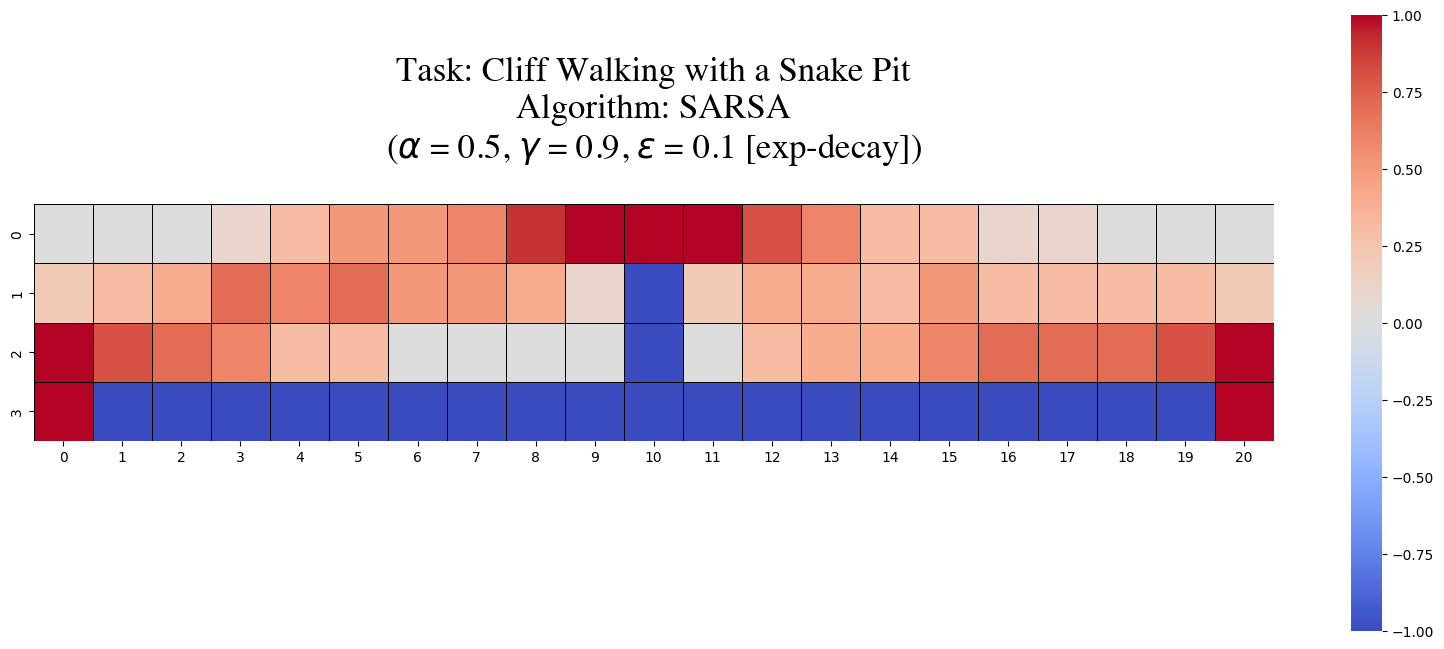

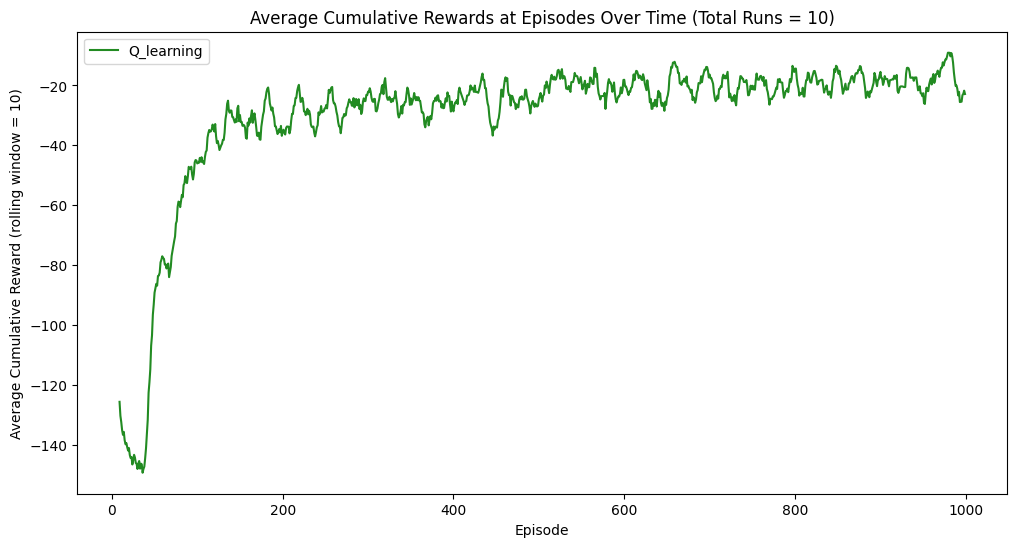

In [256]:
plot_path(avg_path__SnakePit_Q)
smooth_rewards(avg_rewards__SnakePit_Q, "Q_learning")

In [236]:
avg_rewards__SnakePit_SARSA, avg_path__SnakePit_SARSA = simulate_multiple_runs(
    setup = "Snake_Pit", 
    strategy="SARSA", 
    use_replay_buffer = False,
    epsilon = 0.1)

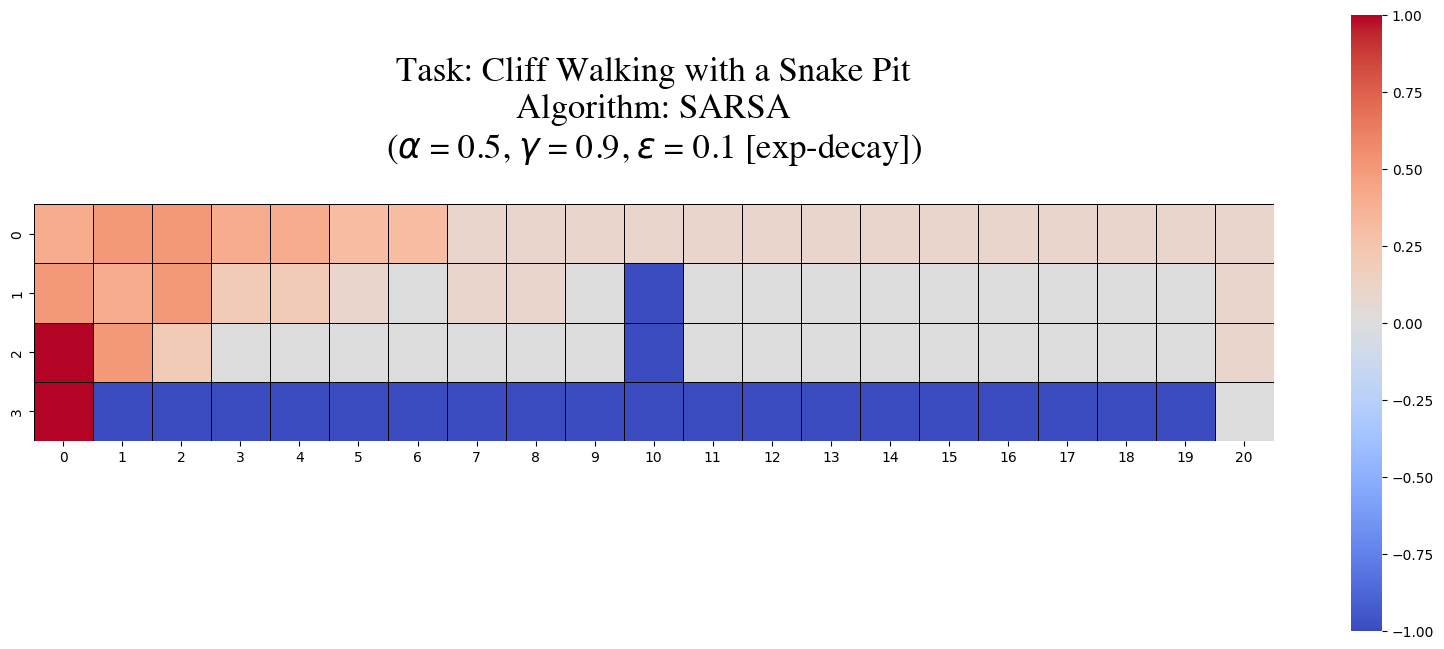

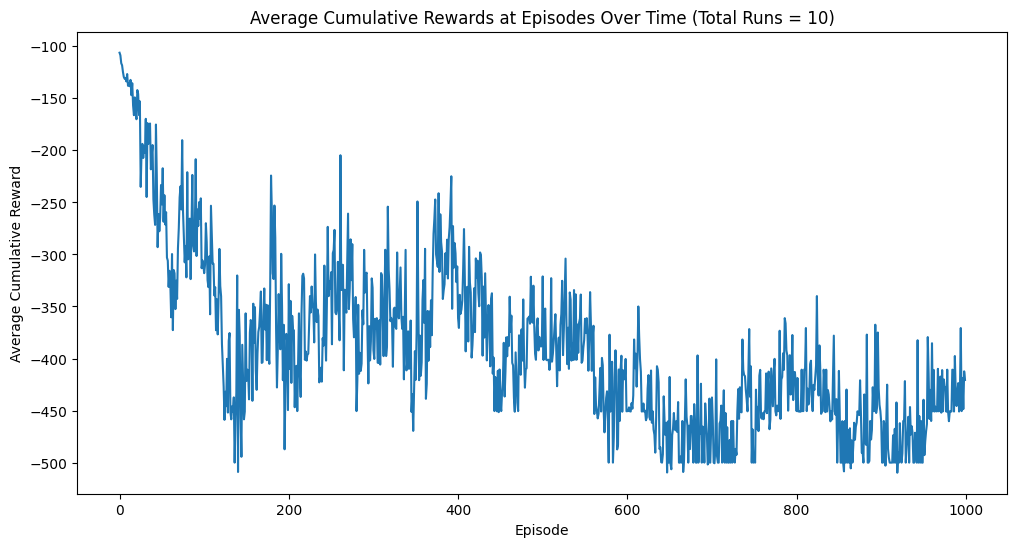

In [237]:
avg_path__SnakePit_SARSA.loc[3,20] = 0
plot_path(avg_path__SnakePit_SARSA)
plot_rewards(avg_rewards__SnakePit_SARSA)

In [238]:
avg_rewards__Normal_Q_Replay, avg_path__Normal_Q_Replay = simulate_multiple_runs(
    setup = "Normal", 
    strategy="Q-learning", 
    use_replay_buffer = True,
    epsilon = 0.1)

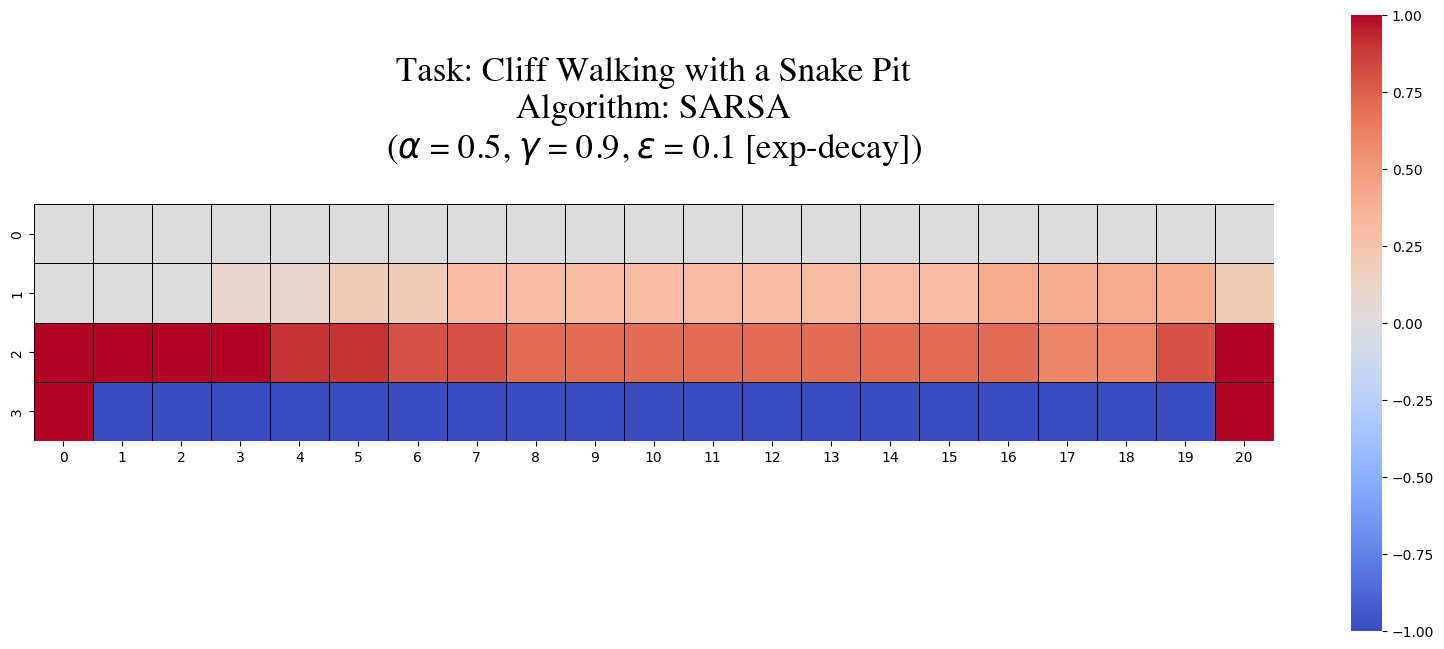

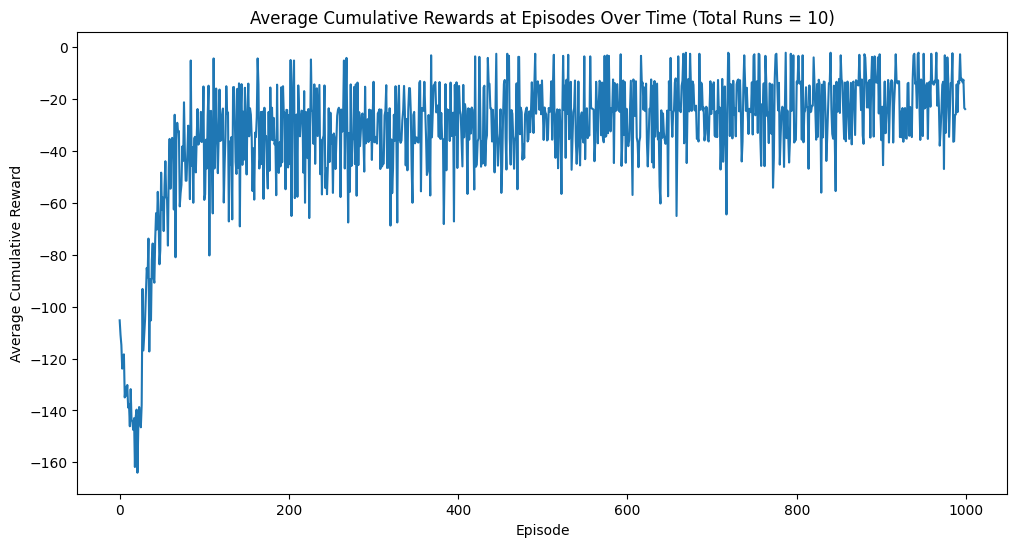

In [260]:
plot_path(avg_path__Normal_Q_Replay)
plot_rewards(avg_rewards__Normal_Q_Replay)

In [239]:
avg_rewards__Normal_Q, avg_path__Normal_Q = simulate_multiple_runs(
    setup = "Normal", 
    strategy="Q-learning", 
    use_replay_buffer = False,
    epsilon = 0.1)

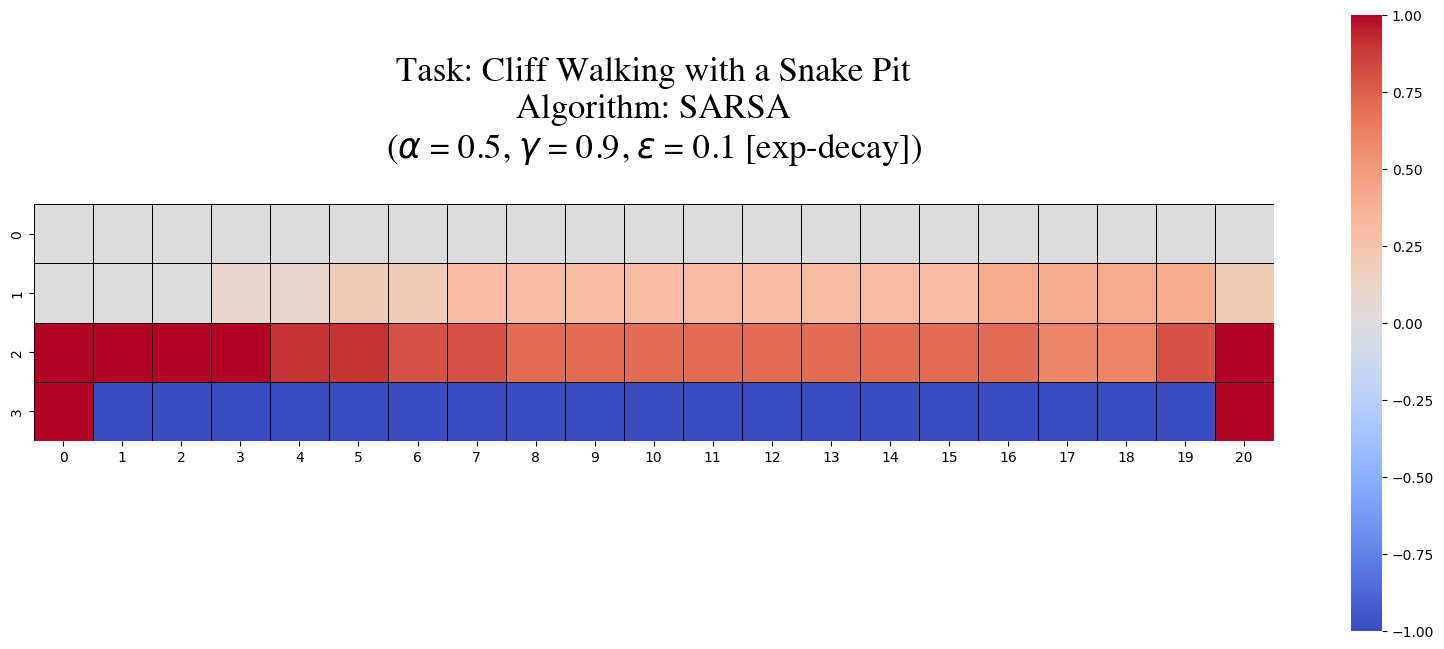

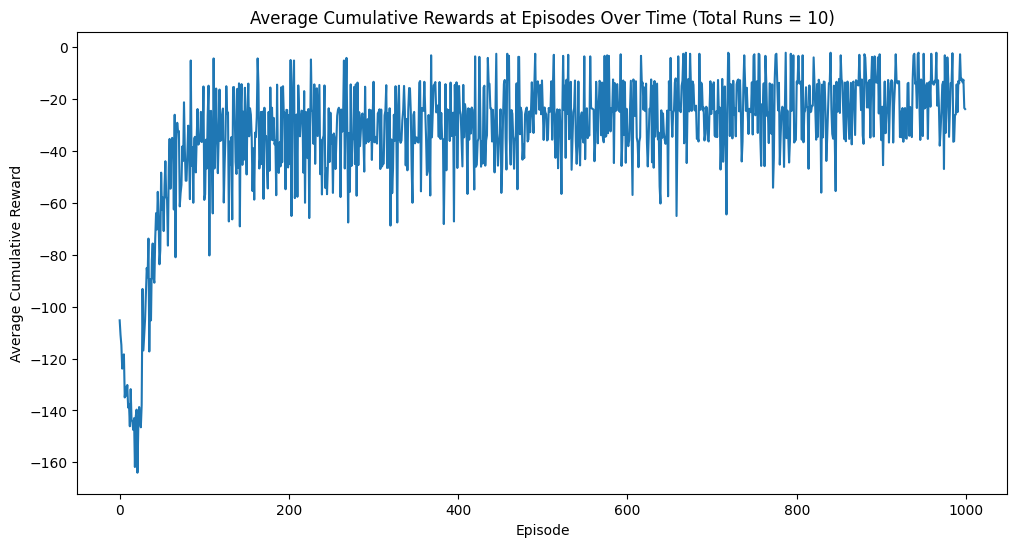

In [259]:
plot_path(avg_path__Normal_Q_Replay)
plot_rewards(avg_rewards__Normal_Q_Replay)

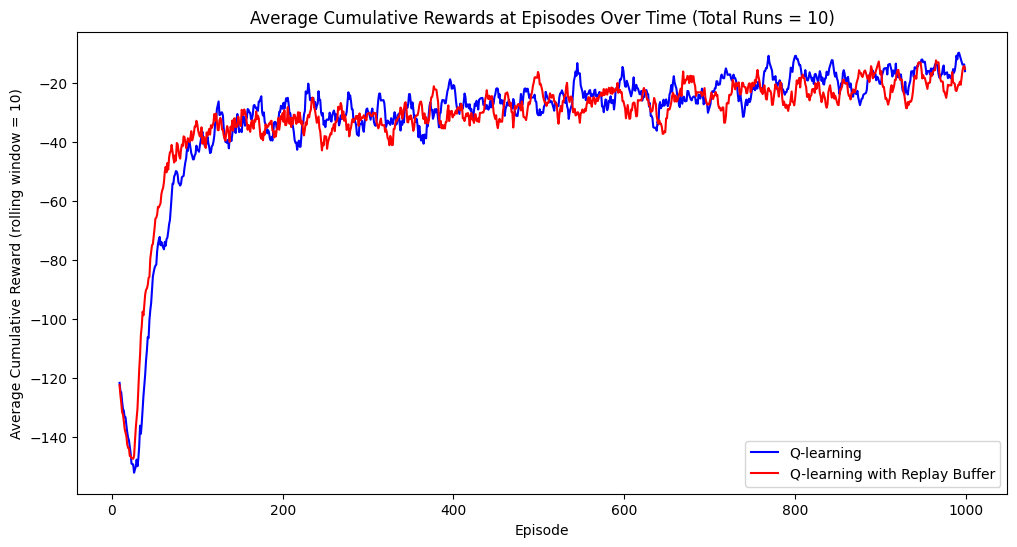

In [258]:
smooth_rewards_two(avg_rewards__Normal_Q, "Q-learning",
                   avg_rewards__Normal_Q_Replay, "Q-learning with Replay Buffer")

In [262]:
avg_rewards__Normal_Q_Replay_E09, avg_path__Normal_Q_Replay_E09 = simulate_multiple_runs(
    setup = "Normal", 
    strategy="Q-learning", 
    use_replay_buffer = True,
    epsilon = 0.9)

In [263]:
avg_rewards__Normal_Q_E09, avg_path__Normal_Q_E09 = simulate_multiple_runs(
    setup = "Normal", 
    strategy="Q-learning", 
    use_replay_buffer = False,
    epsilon = 0.9)

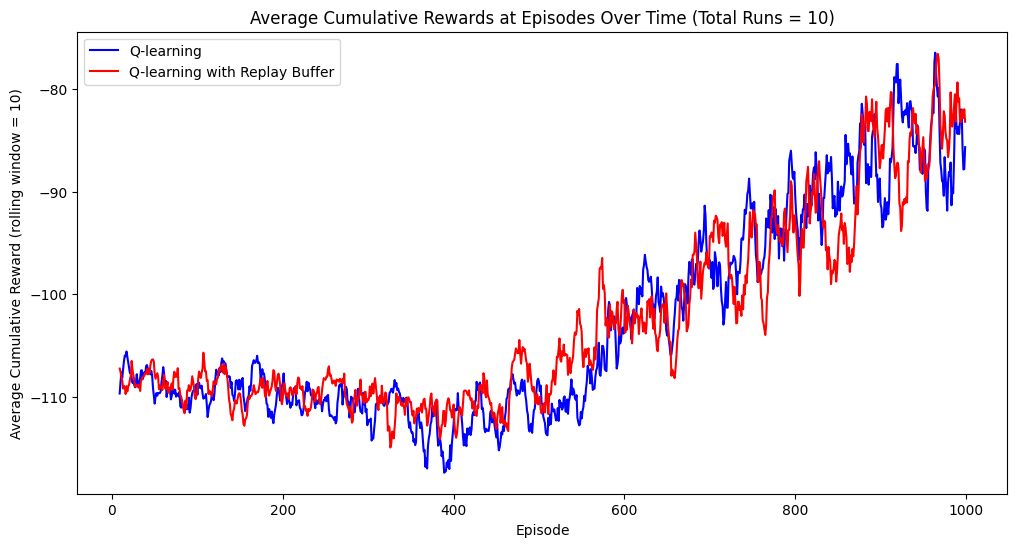

In [264]:
smooth_rewards_two(avg_rewards__Normal_Q_E09, "Q-learning",
                   avg_rewards__Normal_Q_Replay_E09, "Q-learning with Replay Buffer")

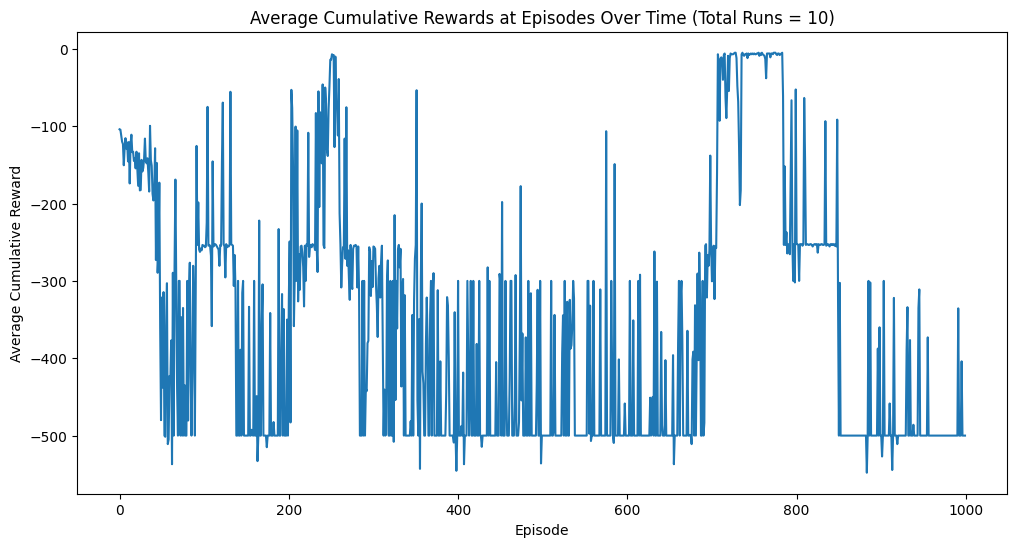

In [218]:
def plot_rewards(rewards):
        import matplotlib.pyplot as plt
        y_values = rewards
        x_values = list(range(1000))
        plt.figure(figsize=(12, 6))
        plt.plot(x_values, y_values)
        plt.title("Average Cumulative Rewards at Episodes Over Time (Total Runs = 10)")
        plt.xlabel("Episode")
        plt.ylabel("Average Cumulative Reward")
        plt.show()

plot_rewards(avg_rewards)

In [105]:
def comparison_plot(configurations, cliff_environment, comparison="epsilon"):
    num_configs = len(configurations)

    fig, axes = plt.subplots(nrows=num_configs, ncols=2, 
                            figsize=(10, 3 * num_configs),  # This adjusts the height of each subplot
                            gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]*num_configs})


    # Run simulations and plot results
    for idx, config in enumerate(configurations):
        if comparison=="epsilon":
            agent = Cliff_Walking(
                cliff_environment=cliff_environment,
                strategy=config['strategy'],
                epsilon=config['initial_epsilon'],
                epsilon_decay=config['epsilon_decay']
            )
        elif comparison=="replay_buffer":
            agent = Cliff_Walking(
                cliff_environment=cliff_environment,
                use_replay_buffer=config["use_replay_buffer"],
                strategy=config['strategy'],
                epsilon=config['initial_epsilon'],
                epsilon_decay=config['epsilon_decay']
            )

        agent.run()

        # Define colors based on the strategy
        if config['strategy'] == 'SARSA':
            cmap = mcolors.ListedColormap(['black', 'white', 'dodgerblue'])
            rewards_color = 'dodgerblue'
        elif config['strategy'] == 'Q-learning':
            cmap = mcolors.ListedColormap(['black', 'white', 'forestgreen'])
            rewards_color = 'forestgreen'
        if config['use_replay_buffer'] == True:
            cmap = mcolors.ListedColormap(['black', 'white', 'red'])
            rewards_color = 'red'


        # Plot Optimal Path
        sns.heatmap(agent.optimal_path, 
                    ax=axes[idx, 0], 
                    linewidths=.5, 
                    cmap=cmap, 
                    cbar=False, 
                    linecolor='black')
        if comparison=="epsilon":
            title = f"Strategy: {config['strategy']}\n$\\epsilon$={config['initial_epsilon']} with {config['epsilon_decay']} decay"
        elif comparison=="replay_buffer":
            title = f"Strategy: {config['strategy']}, Replay Buffer: {config['use_replay_buffer']} \n$\\epsilon$={config['initial_epsilon']} with {config['epsilon_decay']} decay"


        axes[idx, 0].set_title(
            title,
            font="Times", fontsize=15)
        axes[idx, 0].set_aspect('equal', adjustable='box')

        # Plot Rewards
        
        if comparison=="epsilon":
            title = f"Strategy: {config['strategy']}\n$\\epsilon$={config['initial_epsilon']} with {config['epsilon_decay']} decay"
        elif comparison=="replay_buffer":
            title = f"Strategy: {config['strategy']}, Replay Buffer: {config['use_replay_buffer']} \n$\\epsilon$={config['initial_epsilon']} with {config['epsilon_decay']} decay"

        axes[idx, 1].plot(agent.episode_rewards, color=rewards_color)
        axes[idx, 1].set_title(
            title,
            font="Times", fontsize=13)
        axes[idx, 1].set_xlabel(
            "Episode", 
            font="Times", fontsize=11)
        axes[idx, 1].set_ylabel(
            "Cumulative Reward",
            font="Times", fontsize=11)

    # Adjust layout
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

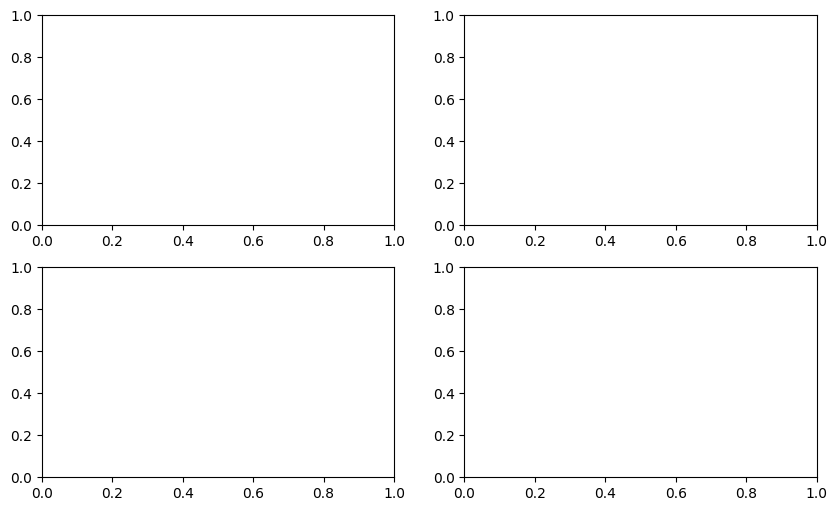

In [88]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for epsilon in epsilons: 
    configurations = [
        {'strategy': 'SARSA', 'epsilon_decay': 'exponential', 'initial_epsilon': epsilon},
        {'strategy': 'Q-learning', 'epsilon_decay': 'exponential', 'initial_epsilon': epsilon},
    ]
    comparison_plot(configurations, cliff_normal)

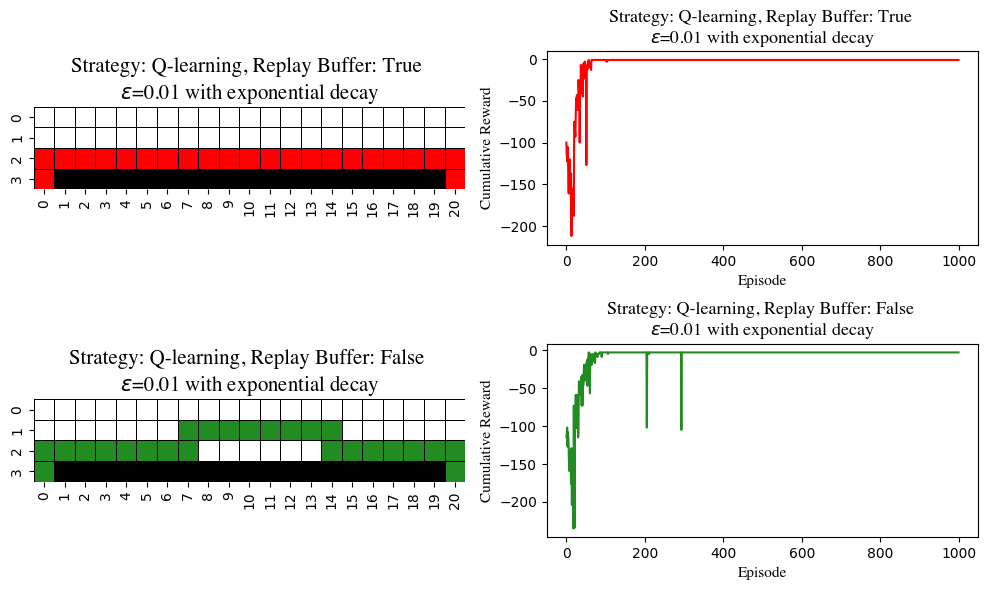

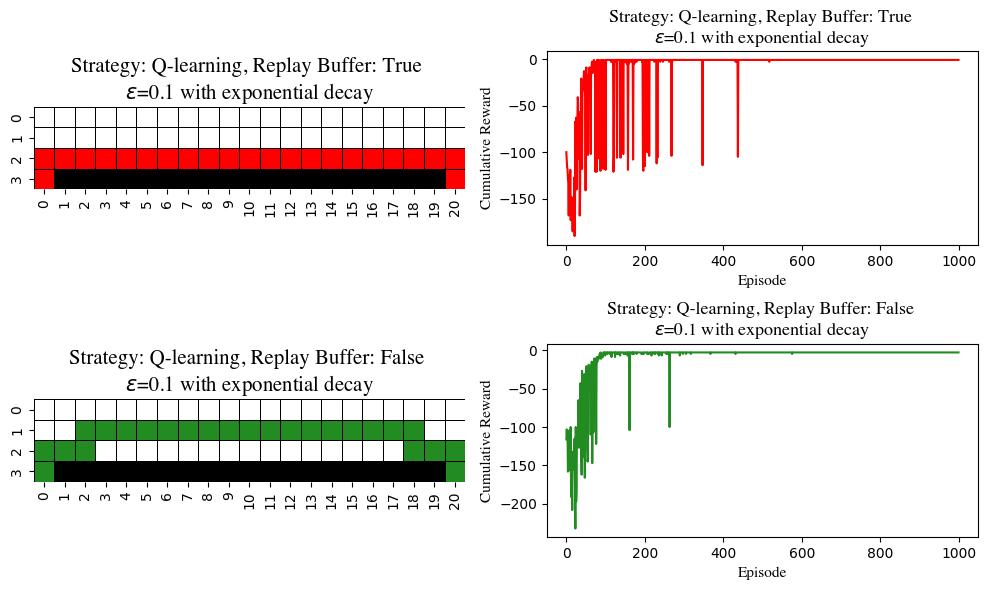

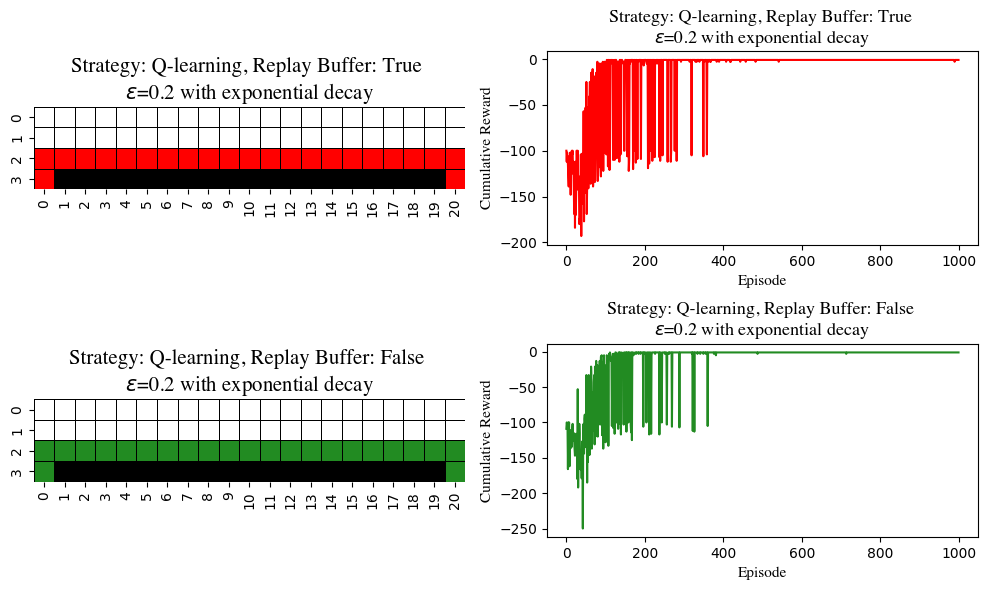

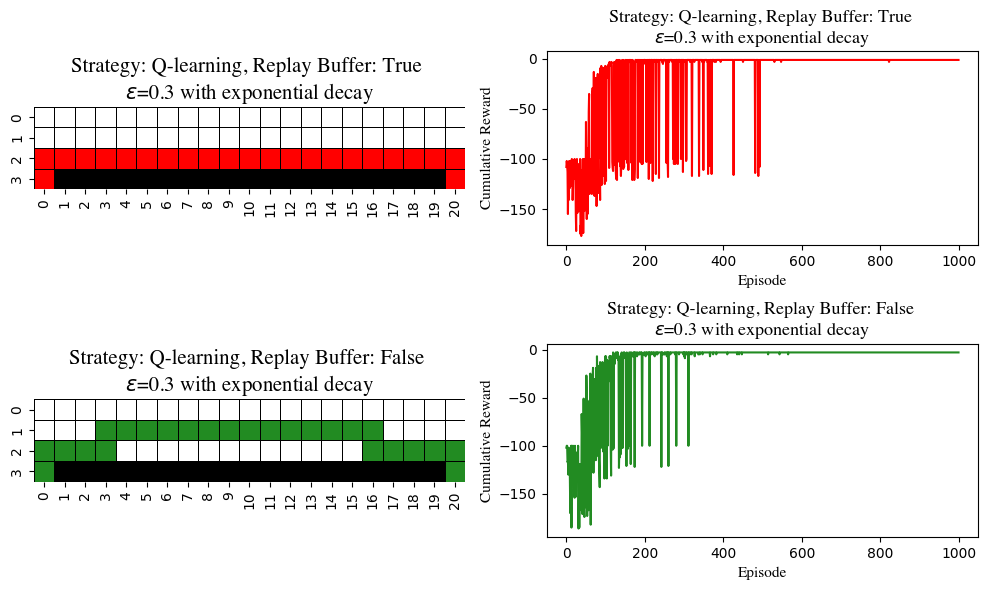

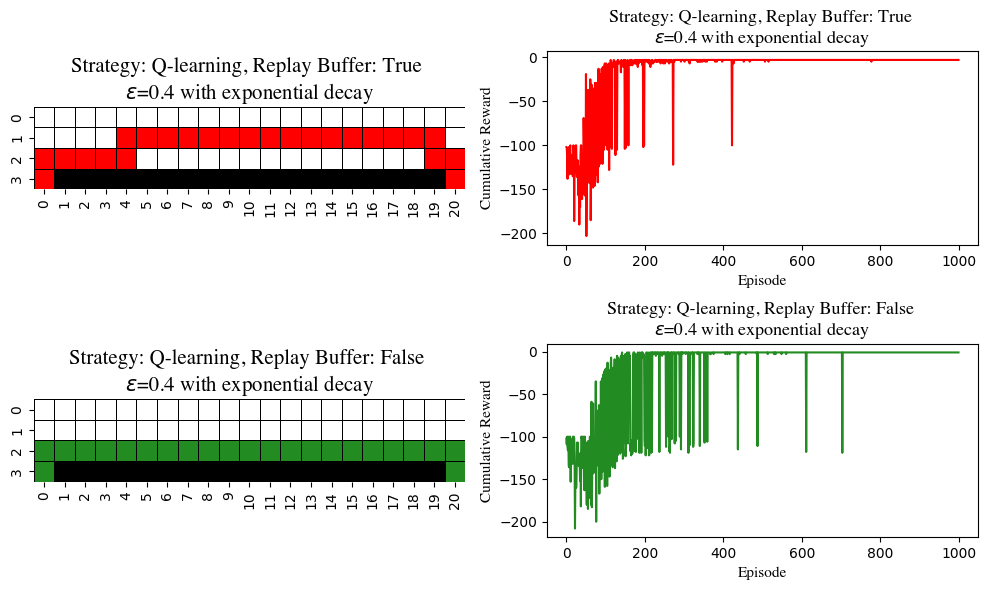

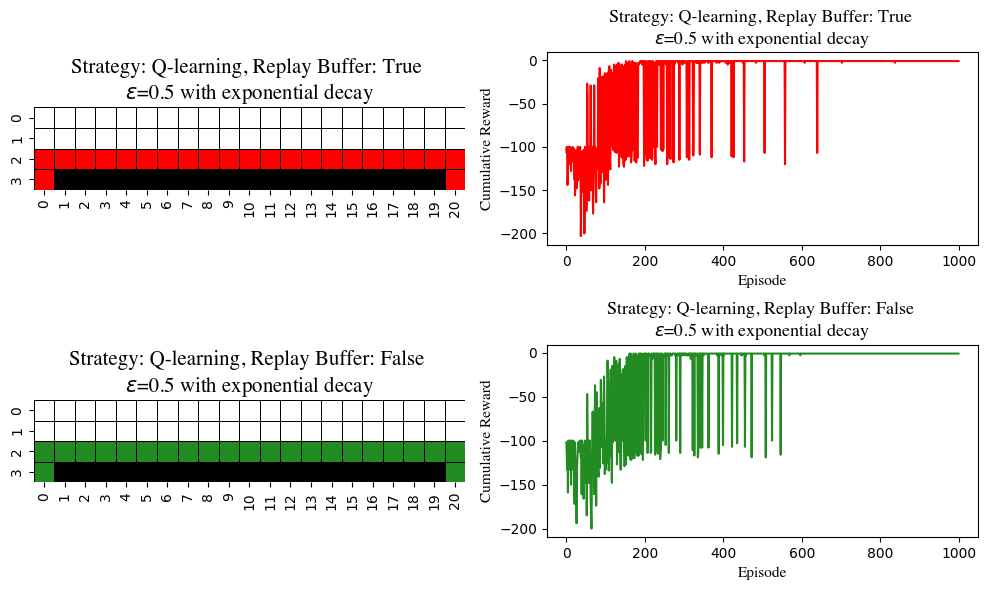

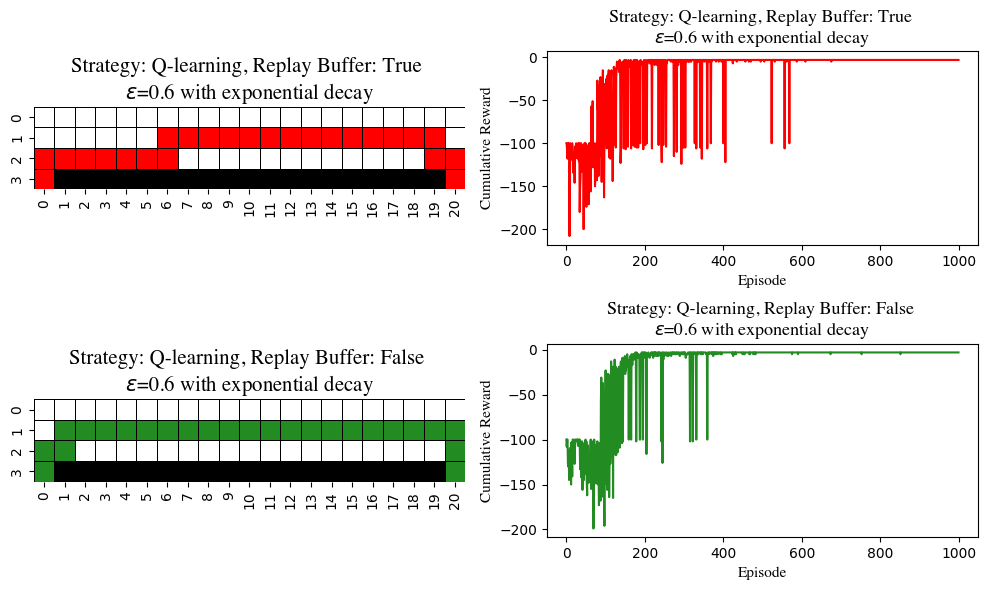

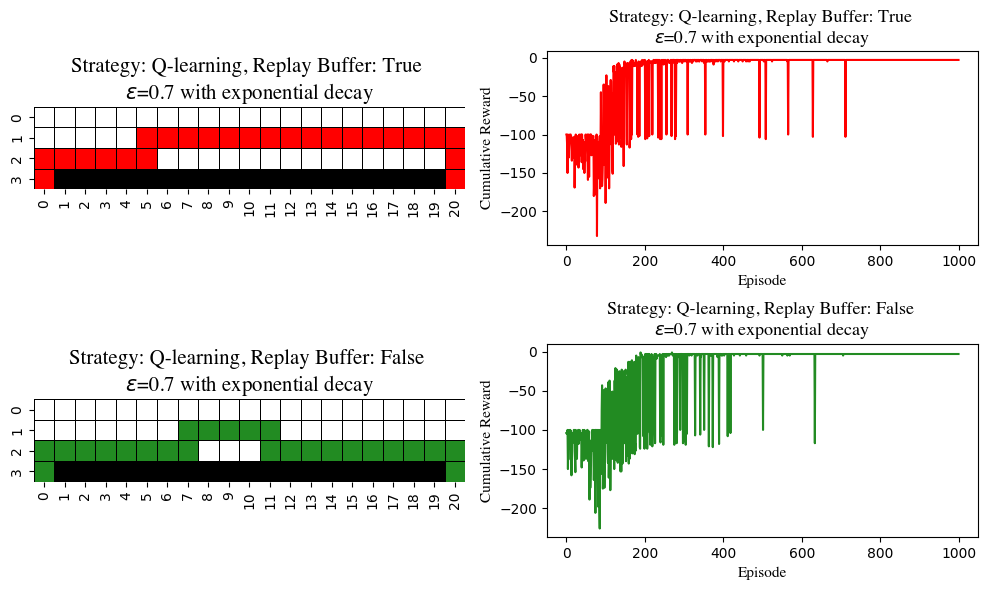

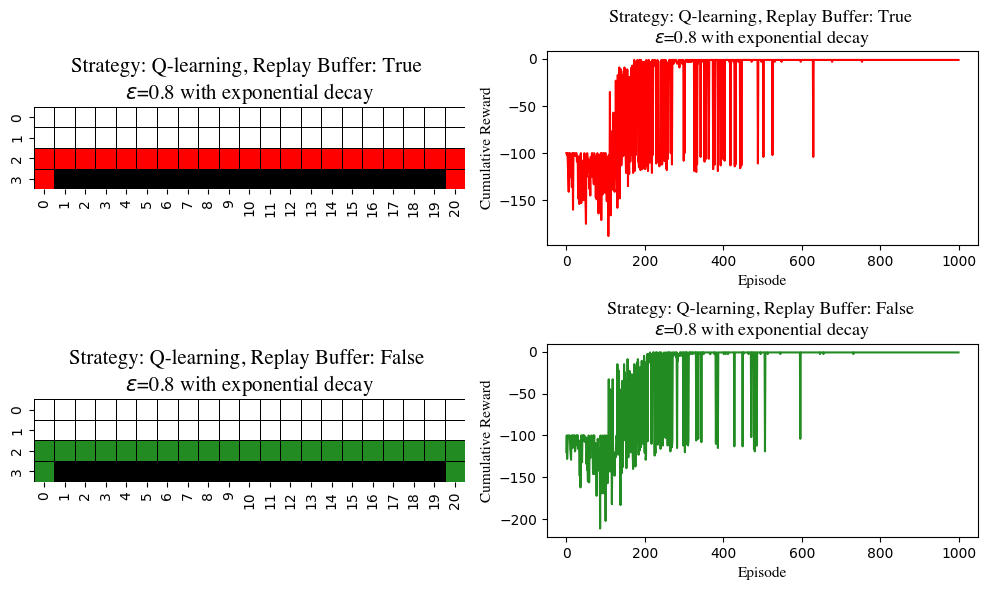

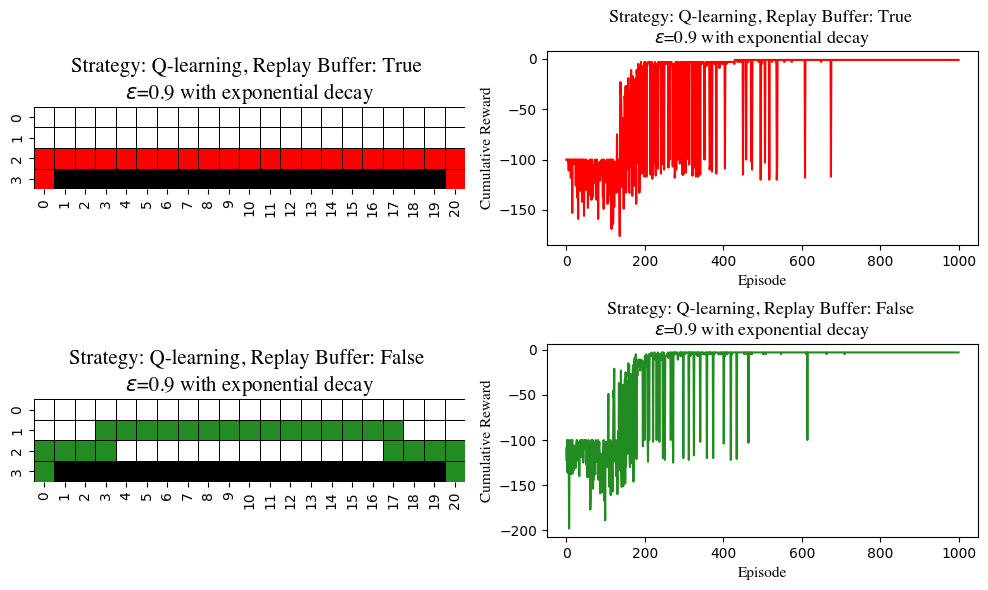

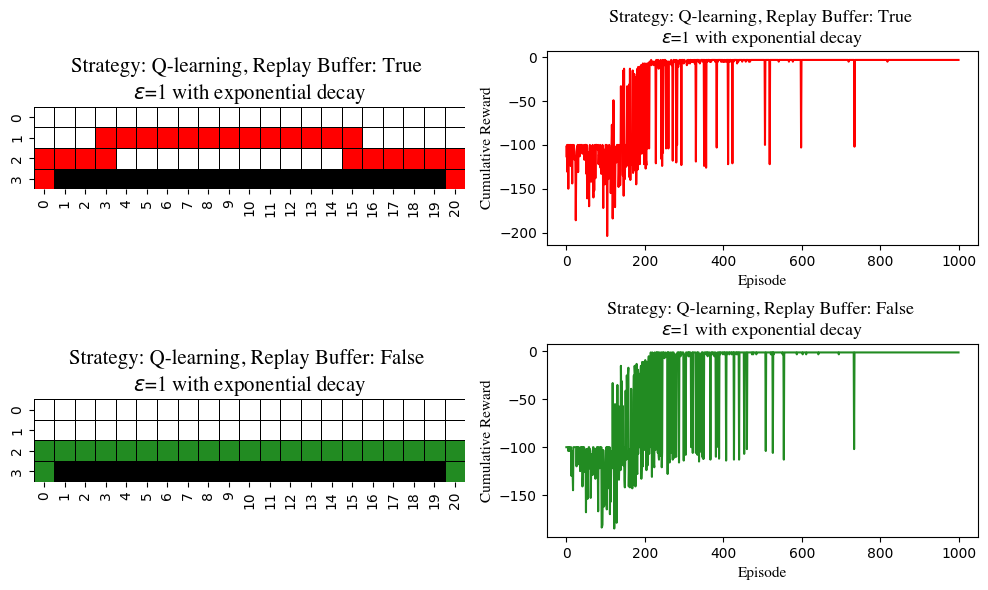

In [106]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for epsilon in epsilons: 
    configurations = [
        {'strategy': 'Q-learning', 'epsilon_decay': 'exponential', 'initial_epsilon': epsilon, "use_replay_buffer": True},
        {'strategy': 'Q-learning', 'epsilon_decay': 'exponential', 'initial_epsilon': epsilon, "use_replay_buffer": False},
    ]
    comparison_plot(configurations, cliff_normal, comparison="replay_buffer")

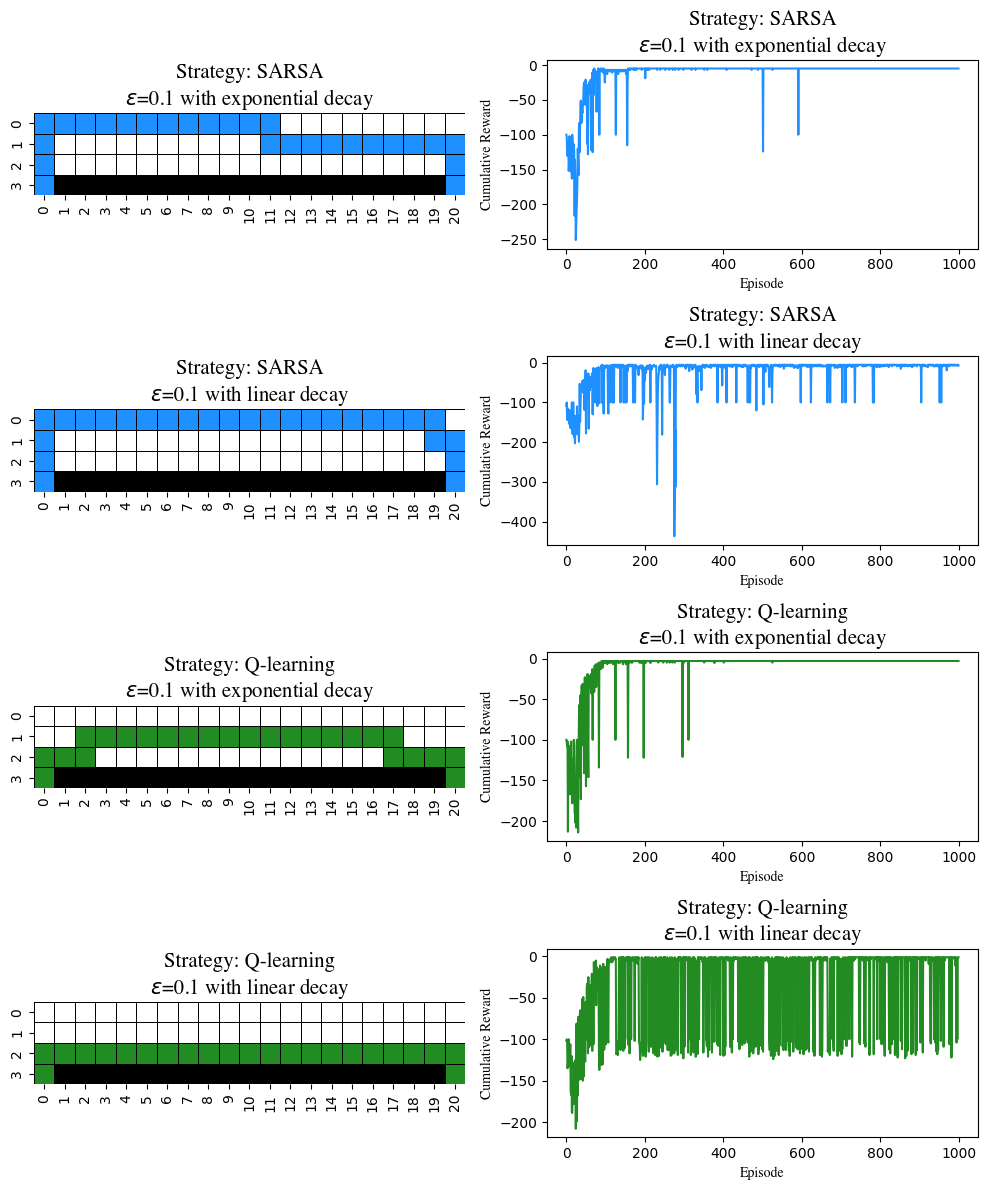

In [30]:
configurations = [
    {'strategy': 'SARSA', 'epsilon_decay': 'exponential', 'initial_epsilon': 0.1},
    {'strategy': 'SARSA', 'epsilon_decay': 'linear', 'initial_epsilon': 0.1},
    {'strategy': 'Q-learning', 'epsilon_decay': 'exponential', 'initial_epsilon': 0.1},
    {'strategy': 'Q-learning', 'epsilon_decay': 'linear', 'initial_epsilon': 0.1, },
]
comparison_plot(configurations, cliff_normal)

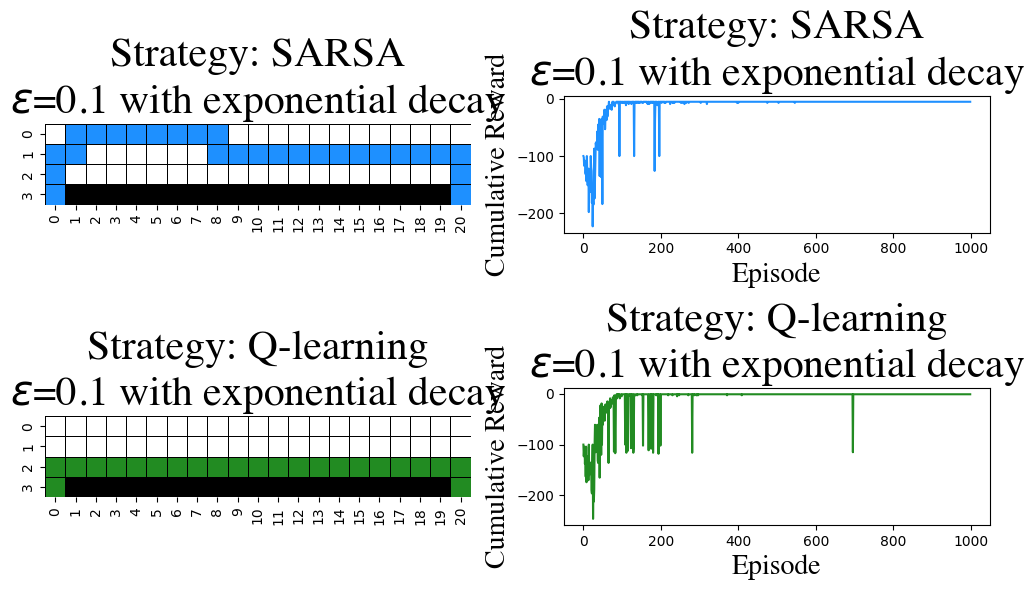

In [24]:
configurations = [
    {'strategy': 'SARSA', 'epsilon_decay': 'exponential', 'initial_epsilon': 0.1},
    {'strategy': 'Q-learning', 'epsilon_decay': 'exponential', 'initial_epsilon': 0.1}
    ]
comparison_plot(configurations, cliff_normal)

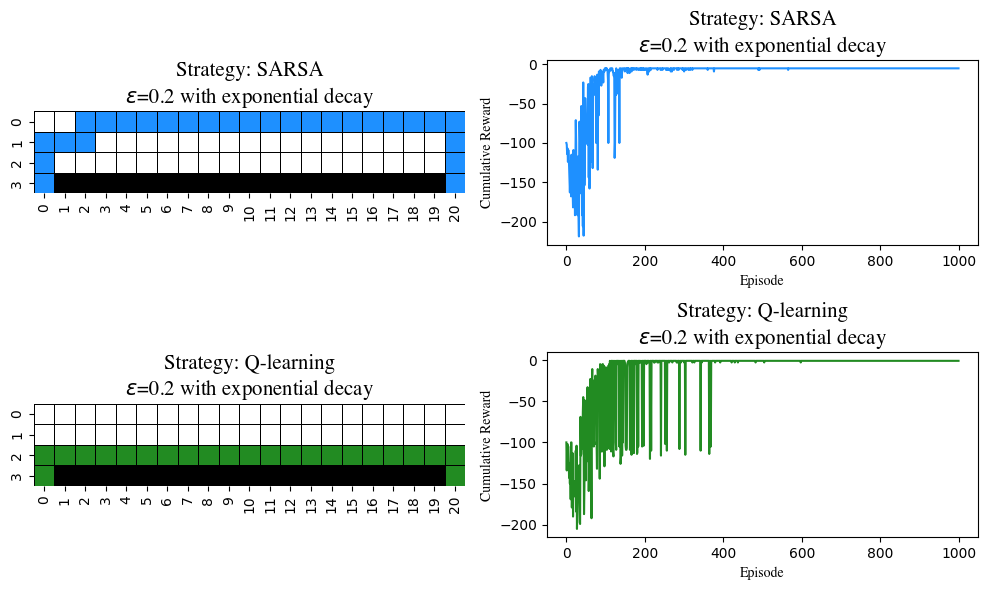

In [26]:
configurations = [
    {'strategy': 'SARSA', 'epsilon_decay': 'exponential', 'initial_epsilon': 0.2},
    {'strategy': 'Q-learning', 'epsilon_decay': 'exponential', 'initial_epsilon': 0.2}
    ]
comparison_plot(configurations, cliff_normal)